In [1]:
import lxml.html as l
import time
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.linear_model import Ridge
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#вспомогательные функции
def dollar(where, mean, num):
    if where != "":
        where = where[1:]
        where = where.split(",")[0]
        mean += int(where.split(",")[0])
    else:
        num += 1
    return where, mean, num
    
def substitute(where, mean):
    if where == "":
        return mean
    else:
        return where

def findOuter(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    if lower_bound < 0:
        lower_bound = np.percentile(data, 5)
    else:
        lower_bound = min(np.percentile(data, 5), lower_bound)
    upper_bound = min(Q3 + 1.5 * IQR, np.percentile(data, 95))
    
    outlier_indices = [i for i, x in enumerate(data) if x < lower_bound or x > upper_bound]
    
    return outlier_indices, IQR, lower_bound, upper_bound

def clearTheArea():
    train = []
    valid = []
    test = []
    Mse = [train, valid, test]
    return Mse, train, valid, test

def fitTheModel(ridge_model, Mse, x_train, y_train, x_valid, y_valid, x_test, y_test):
    ridge_model.fit(x_train, y_train)
    Mse[0].append(mse(ridge_model.predict(x_train), y_train, squared=False))
    Mse[1].append(mse(ridge_model.predict(x_valid), y_valid, squared=False))
    Mse[2].append(mse(ridge_model.predict(x_test), y_test, squared=False))

def showTheModel(k, Mse, plt):
    plt.plot(k, Mse[0], label='Train')
    plt.plot(k, Mse[1], label='Valid')
    plt.plot(k, Mse[2], label='Test')
    plt.legend()
    plt.show()


In [3]:
file_paths = ['data284.csv', 'data381.csv', 'data621.csv']
files = ['train.csv', 'valid.csv', 'test.csv']

In [4]:
df1 = pd.read_csv(file_paths[0])
df2 = pd.read_csv(file_paths[1])
df3 = pd.read_csv(file_paths[2])

combined_df = pd.concat([df1, df2, df3], ignore_index=True)

combined_df.to_csv("data.csv", index=False)

In [5]:
#Предобработка данных
# for number in [0,1,2]:
dataN=[0,7,8,9,18,26,28,19,21,20]
with open('dataProcessed.csv', 'w', newline='', encoding='utf-8') as data:
    meanB = 0
    numB = 0
    meanUSA = 0
    numUSA = 0
    meanRUS = 0
    numRUS = 0
    meanWLD = 0
    numWLD = 0
    with open('data.csv', 'r', newline='', encoding='utf-8') as file:
        cat=file.readline().split(",")
        fieldNames = []
        for i in dataN:
            fieldNames.append(cat[i])
        writer = csv.DictWriter(data, fieldnames=fieldNames,
                            extrasaction='ignore')
        writer.writeheader()
        dat = list(csv.reader(file, skipinitialspace=True))
        dict={}
        
        for line in dat:  
            if (line[18] != "" and line[18][0] != "$") or (line[19] != "" and line[19][0] != "$") or (line[21] != "" and line[21][0] != "$"):
                continue
            line[18], meanB, numB = dollar(line[18], meanB, numB)
            line[19], meanUSA, numUSA = dollar(line[19], meanUSA, numUSA)
            line[21], meanRUS, numRUS = dollar(line[21], meanRUS, numRUS)
            if line[20] != "":
                s = line[20].split("= $")
                if len(s) > 1:
                    line[20] = s[1]
                else:
                    line[20] = line[20][1:]
                line[20] = line[20].split(",")[0]
                meanWLD += int(line[20])
                # print(line[20])
            else:
                numWLD += 1
            line[26] = line[26][:len(line[26]) - 1]
            line[28] = line[28].split(" ")[0]
            j = 0
            for i in dataN:
                dict[fieldNames[j]] = line[i]
                j += 1
            writer.writerow(dict)
with open('dataProcessed.csv', 'r+', newline='', encoding='utf-8') as data:
    with open('finalized.csv', 'w', newline='', encoding='utf-8') as file:
        dat = list(csv.reader(data, skipinitialspace=True))
        writer = csv.DictWriter(file, fieldnames=dat[0],
                                extrasaction='ignore')
        writer.writeheader()
        nums = [4, 7, 9, 8]
        meanB = round(meanB / numB)
        meanUSA = round(meanUSA / numUSA)
        meanRUS = round(meanRUS / numRUS)
        meanWLD = round(meanWLD / numWLD)
        cnt = 1
        fieldnames = dat[0] 
        for line in dat[1:]:
            line[1] = line[1].split(",")[0]
            line[4] = substitute(line[4], meanB)
            line[7] = substitute(line[7], meanUSA)
            line[8] = substitute(line[8], meanRUS)
            line[9] = substitute(line[9], meanWLD)
            dat[cnt] = line
            cnt += 1
            
        #Удалим выбросы
        dict = {}
        WLD = [int(row[9]) for row in dat[1:]]
        
        outlier_indices, IQR, lower_bound, upper_bound = findOuter(WLD)
        
        print("Среднее:", np.mean(WLD))
        print("IQR:", IQR)
        print("Границы выбросов:", lower_bound, upper_bound)
        print("Индексы выбросов:", outlier_indices)
        print("Выброшенные значения:", [WLD[i] for i in outlier_indices])

        dele = 0
        for i in dat[1:]:
            if dele in outlier_indices:
                dele += 1
                continue
            cnt = 0
            # print(dele)
            # print(i)
            for j in fieldnames:
                dict[j] = i[cnt]
                cnt += 1
            writer.writerow(dict)
            dele += 1
            # print(dict)

Среднее: 480007478.8625828
IQR: 945883140.75
Границы выбросов: 6750225.25 1046658907.0
Индексы выбросов: [1, 47, 49, 57, 64, 77, 112, 162, 163, 164, 165, 186, 210, 216, 225, 263, 267, 272, 290, 291, 297, 308, 311, 321, 322, 323, 349, 361, 385, 404, 409, 430, 435, 437, 445, 448, 468, 469, 475, 486, 496, 499, 500, 509, 568, 581, 597, 603, 608, 628, 630, 642, 651, 652, 655, 670, 684, 686, 699, 711, 718, 721, 731, 733, 745, 747, 761, 791, 813, 842, 854, 856, 879, 880, 887, 904, 936, 937, 941, 958, 968, 976, 994, 996, 1035, 1037, 1054, 1060, 1062, 1104, 1122, 1123, 1142, 1146, 1156, 1166, 1169, 1174, 1178]
Выброшенные значения: [6149746, 1073394593, 2320250281, 5184368, 21981, 224910, 6193234, 614316, 4935501, 5998707, 1819252, 690196, 14626, 5276805, 1671700, 877783, 6550, 1090116, 4849240, 1236005118, 1550834, 60598, 1056057273, 9928, 2276024, 1104054072, 13518, 1332539889, 2087809, 309027, 1526248, 20943, 638726, 481234, 4366460, 20192, 1263521126, 4459303, 394717, 3339676, 1034769, 1108

In [6]:
with open('finalized.csv', 'r', newline='', encoding='utf-8') as data:
    dat = list(csv.reader(data, skipinitialspace=True))
    WLD = [int(row[9]) for row in dat[1:]]
    print(min(WLD))
    print(dat[0])

6850036
['Название', 'Год производства', 'Страна', 'Жанр', 'Бюджет', 'Возраст', 'Время', 'Сборы в США', 'Сборы в России', 'Сборы в мире']


In [7]:
df = pd.read_csv('finalized.csv')
df.isnull().sum()
df = df.fillna(df.mean())
SScaler  = StandardScaler()
colNum = ['Год производства', 'Бюджет', 'Возраст', 'Время', 'Сборы в США', 'Сборы в России']
df[colNum] = SScaler.fit_transform(df[colNum])
# print(df)
colLet = ['Название', 'Страна', 'Жанр']
oneHot = OneHotEncoder(sparse=False, drop='first')
oData = oneHot.fit_transform(df[colLet])
dfEncoded = pd.DataFrame(oData, columns=oneHot.get_feature_names_out(colLet))
df = pd.concat([df, dfEncoded], axis=1)
df = df.drop(colLet, axis=1)
df.head()

C:\Users\Игорь\AppData\Local\Temp\ipykernel_9332\276736719.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())
C:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Год производства,Бюджет,Возраст,Время,Сборы в США,Сборы в России,Сборы в мире,Название_007: СПЕКТР,Название_100 вещей и ничего лишнего,Название_12 лет рабства,...,"Жанр_фэнтези, семейный, мелодрама, приключения","Жанр_фэнтези, триллер, драма","Жанр_фэнтези, триллер, драма, детектив","Жанр_фэнтези, триллер, драма, криминал, детектив","Жанр_фэнтези, триллер, мелодрама","Жанр_фэнтези, триллер, ужасы, боевик","Жанр_фэнтези, ужасы, боевик, детектив","Жанр_фэнтези, ужасы, драма, детектив","Жанр_фэнтези, ужасы, триллер, драма, детектив",Жанр_nan
0,-0.605945,-0.742162,0.358855,0.342518,-1.055626,0.733021,144056873,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.248494,-1.209192,0.758150,0.367129,-1.351100,-1.114281,33678406,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.559198,-1.120835,0.758150,0.588624,-1.013074,-1.308499,98690254,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.237145,1.234771,-2.835502,-2.143153,1.240813,0.733021,1046658907,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.605945,-0.426602,-0.439734,0.022580,-0.609771,0.733021,248118121,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


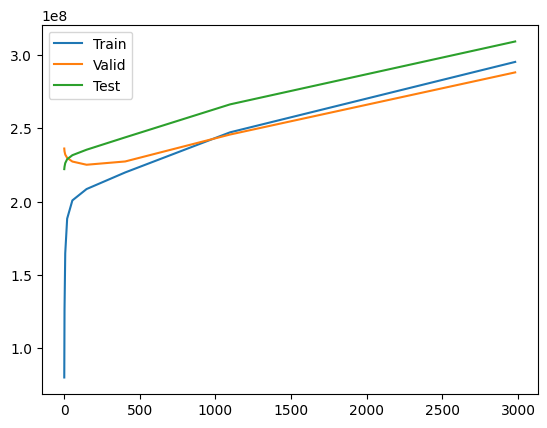

In [8]:
x_train, x_tmp, y_train, y_tmp = train_test_split(df.drop(['Сборы в мире'], axis=1), df['Сборы в мире'], test_size=0.2, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42)

k = [np.exp(i) for i in range(9)]
Mse, train, valid, test = clearTheArea()
for i in k:
    model = Ridge(alpha=i)
    fitTheModel(model, Mse, x_train, y_train, x_valid, y_valid, x_test, y_test)
showTheModel(k, Mse, plt)

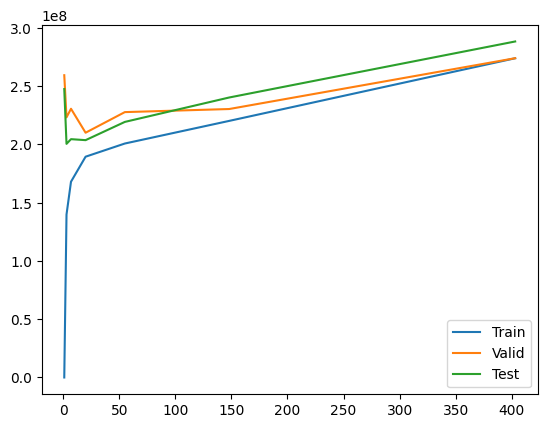

In [9]:
k = [round(np.exp(i)) for i in range(7)]
Mse, train, valid, test = clearTheArea()
for i in k:
    model = KNeighborsRegressor(n_neighbors=i)
    fitTheModel(model, Mse, x_train, y_train, x_valid, y_valid, x_test, y_test)
showTheModel(k, Mse, plt)

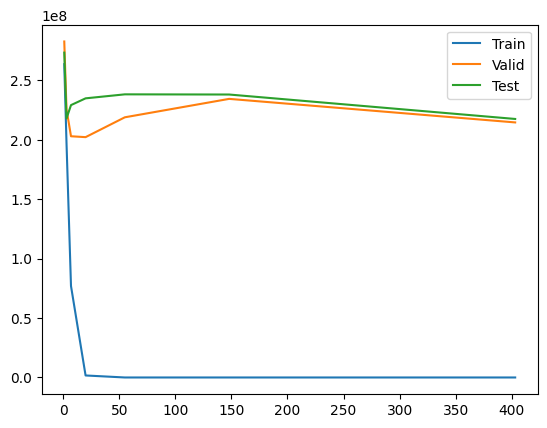

In [10]:
k = [round(np.exp(i)) for i in range(7)]
Mse, train, valid, test = clearTheArea()
for i in k:
    model = DecisionTreeRegressor(max_depth=i)
    fitTheModel(model, Mse, x_train, y_train, x_valid, y_valid, x_test, y_test)
showTheModel(k, Mse, plt)

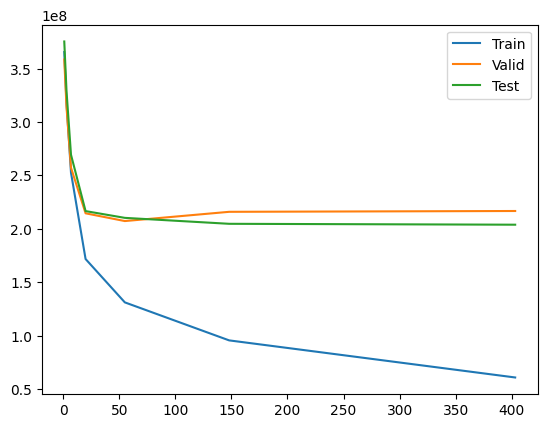

In [11]:
k = [round(np.exp(i)) for i in range(7)]
Mse, train, valid, test = clearTheArea()
for i in k:
    model = GradientBoostingRegressor(n_estimators=i)
    fitTheModel(model, Mse, x_train, y_train, x_valid, y_valid, x_test, y_test)
showTheModel(k, Mse, plt)